In [1]:
import cv2
import os
import pandas as pd
import numpy as np
from PIL import Image
import random
%matplotlib inline

In [2]:
def convert_paths(df, folder):
    #convert paths of datalog to those on local computer
    for i in range(len(df)):
        for col in ['img_center', 'img_left', 'img_right']:
            file = df.ix[i, col].split('/')[-1]
            img_path = os.path.join(img_folder, file)
            df.ix[i, col] = img_path
    return df

def load_datasets(folders):
    #load datasets from multiple folders
    dataframes = []
    for folder in folders:
        df = pd.read_csv(os.path.join(folder, 'driving_log.csv'))
        df.columns = ['img_center', 'img_left', 'img_right', 'steering', 'throttle', 'break', 'speed']
        df = convert_paths(df, folder)
        dataframes.append(df)
    df = pd.concat(dataframes)
    return df



In [3]:
data_path = '/home/ubuntu/udacity_projects/P3_behavioral_cloning/driving_data/'
track1_path = os.path.join(data_path, 'track_1')
img_folder = os.path.join(track1_path, 'IMG')

folders = [track1_path]
df = load_datasets(folders)

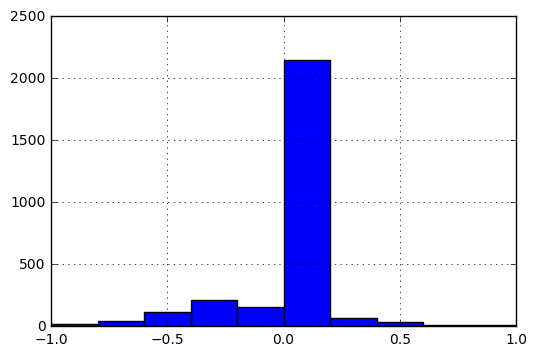

In [4]:

df['steering'].hist()

In [5]:
ix = df[(df['steering'] > -.1) & (df['steering'] < .1) ].index

In [6]:
arr = list(ix.get_values())
ix_remove = random.sample(arr, round(len(arr) * .8))
ix_remove = df.index.isin(ix_remove)
df_curves = df[~ix_remove]
len(df_curves)

1079

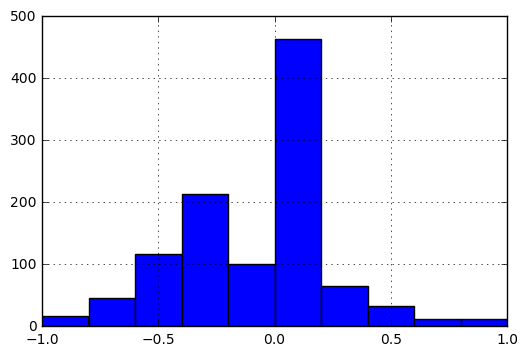

In [7]:
df_curves['steering'].hist()

In [8]:


def get_data(row, img_col, 
             steering_col='steering', steering_adjust=.1):
    
    img = Image.open(df[img_col][row])
    img_arr = np.array(img)
    angle = df[steering_col][row] + steering_adjust
    return img_arr, angle


def data_gen(df, batch_size=32, adjust=.1, sample_ix=None):
    arg_choices = [{'img_col': 'img_center', 'adjust': 0.0},
                   {'img_col': 'img_left',   'adjust': adjust},
                   {'img_col': 'img_right',  'adjust': -adjust},]
       
    if sample_ix is None:
        sample_ix = list(range(len(df)))
        random.shuffle(sample_ix)
    
    #print(df.head())
    while True:
        images=[]
        angles=[]
        rows = sample_ix[:batch_size]
        for i in rows:
            args = random.choice(arg_choices)
            img, angle = get_data(i, args['img_col'], steering_adjust=args['adjust'])

            
            flip = random.randint(0, 1)
            if flip == 1:
                img = np.fliplr(img)
                angle = -angle
                
            images.append(img)
            angles.append(angle)

        X_train = np.array(images)
        y_train = np.array(angles)
        yield X_train, y_train

In [25]:
#create index of all data
df = df_curves.reset_index(drop=True)

In [26]:

n = len(df)
sample_ix = list(range(n))
random.shuffle(sample_ix)

#separate index into train and validation
train_n = round(n * .8)
train_ix = sample_ix[:train_n]
val_ix = sample_ix[train_n:]

#create data generators with those indexes
train_gen = data_gen(df, sample_ix=train_ix)
val_gen = data_gen(df, sample_ix=val_ix)


In [39]:
import keras
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, SimpleRNN, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Cropping2D, Lambda
from keras.regularizers import l2


def build_model():
    '''
    Function to create models with convolutional heads and dense tails.
    Accepts dictionaries defining the conv and dense layers.
    '''

    img_in = Input(shape=(160, 320,3), name='img_in')
    x = Lambda(lambda x: (x / 255.0) - 0.5)(img_in)
    x = Cropping2D(cropping=((70, 25), (0, 0)))(x)
    x = Convolution2D(24, (5,5), strides=(2,2), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(32, (5,5), strides=(2,2), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(48, (5,5), strides=(2,2), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(64, (3,3), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(64, (3,3), activation='elu', kernel_regularizer=l2(0.001))(x)

    
    x = Flatten(name='flattened')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(.4)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(.3)(x)
    angle = Dense(1)(x)
    
    model = Model(inputs=[img_in], outputs=[angle])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

In [40]:
model = build_model()

In [42]:
model.fit_generator(train_gen, 100, epochs=10, validation_data=val_gen, validation_steps=20)
    

Epoch 1/10
100/100 [==============================] - 7s - loss: 0.1169 - val_loss: 0.2814
Epoch 2/10
100/100 [==============================] - 7s - loss: 0.1039 - val_loss: 0.2703
Epoch 3/10
100/100 [==============================] - 7s - loss: 0.0956 - val_loss: 0.2767
Epoch 4/10
100/100 [==============================] - 6s - loss: 0.0891 - val_loss: 0.2789
Epoch 5/10
100/100 [==============================] - 7s - loss: 0.0831 - val_loss: 0.2573
Epoch 6/10
100/100 [==============================] - 7s - loss: 0.0782 - val_loss: 0.2700
Epoch 7/10
100/100 [==============================] - 7s - loss: 0.0729 - val_loss: 0.2630
Epoch 8/10
100/100 [==============================] - 7s - loss: 0.0714 - val_loss: 0.2762
Epoch 9/10
100/100 [==============================] - 7s - loss: 0.0703 - val_loss: 0.2707
Epoch 10/10
100/100 [==============================] - 7s - loss: 0.0660 - val_loss: 0.2692


In [43]:
model.save('model.hdf5')

In [52]:
imgs, angles = next(train_gen)

In [53]:
model.predict(imgs[:3])

array([[ 0.00306399],
       [ 0.003748  ],
       [-0.09513991]], dtype=float32)